## 'Goodbooks ’ Recommendation Engine Spark ALS

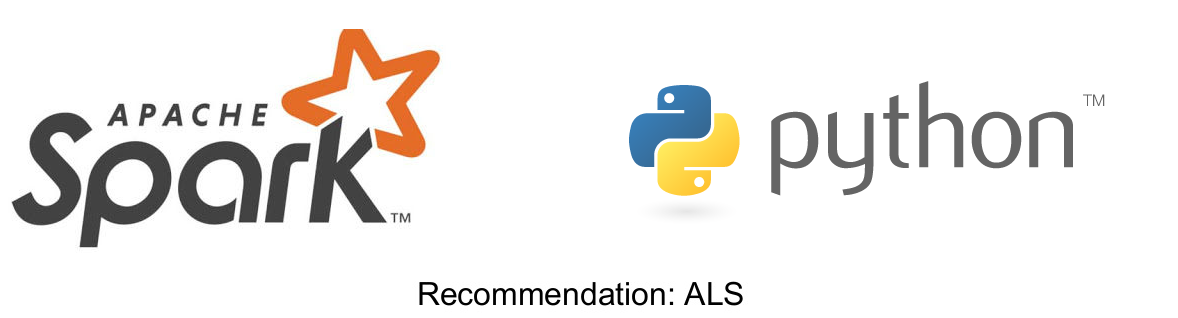

In [ ]:
!pip install pyspark 

#user permission 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/"

#data collection 

In [ ]:
!kaggle datasets download -d zygmunt/goodbooks-10k

 60% 7.00M/11.6M [00:00<00:00, 72.0MB/s]
100% 11.6M/11.6M [00:00<00:00, 74.6MB/s]


In [ ]:
!ls

books.csv      gdrive		  ratings.csv	   sample_data	to_read.csv
book_tags.csv  goodbooks-10k.zip  sample_book.xml  tags.csv


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  goodbooks-10k.zip
replace book_tags.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: book_tags.csv           
replace books.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: books.csv               
replace ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ratings.csv             
replace sample_book.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_book.xml         
replace tags.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: tags.csv                
replace to_read.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: to_read.csv             


## Import the libraries

In [ ]:
import pyspark as ps
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator##Error evaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder## Hyper parameters
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import udf, col, when
import numpy as np


## Creat Spark

In [ ]:
spark = ps.sql.SparkSession.builder \
            .master("local") \
            .appName("book") \
            .getOrCreate() 
            
sc = spark.sparkContext 
sqlContext = SQLContext(sc)

## Reaad Data

In [ ]:
ratings_df = spark.read.csv('/content/ratings.csv',header=True, inferSchema=True)
ratings_df.printSchema()

root
 |-- book_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [ ]:
ratings_df.show(5)

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|    314|     5|
|      1|    439|     3|
|      1|    588|     5|
|      1|   1169|     4|
|      1|   1185|     4|
+-------+-------+------+
only showing top 5 rows



In [ ]:
books_df = spark.read.csv('/content/books.csv',header=True, inferSchema=True) 
books_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- best_book_id: integer (nullable = true)
 |-- work_id: integer (nullable = true)
 |-- books_count: integer (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: double (nullable = true)
 |-- authors: string (nullable = true)
 |-- original_publication_year: double (nullable = true)
 |-- original_title: string (nullable = true)
 |-- title: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- ratings_count: string (nullable = true)
 |-- work_ratings_count: string (nullable = true)
 |-- work_text_reviews_count: string (nullable = true)
 |-- ratings_1: double (nullable = true)
 |-- ratings_2: integer (nullable = true)
 |-- ratings_3: integer (nullable = true)
 |-- ratings_4: integer (nullable = true)
 |-- ratings_5: integer (nullable = true)
 |-- image_url: string (nullable = true)
 |-- small_image_url: string (nullable = true)


In [ ]:
books_df.show(1)

+---+-------+------------+-------+-----------+---------+----------------+---------------+-------------------------+----------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------+--------------------+
| id|book_id|best_book_id|work_id|books_count|     isbn|          isbn13|        authors|original_publication_year|  original_title|               title|language_code|average_rating|ratings_count|work_ratings_count|work_text_reviews_count|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|           image_url|     small_image_url|
+---+-------+------------+-------+-----------+---------+----------------+---------------+-------------------------+----------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------+--------------------+
|  1

In [ ]:
training_df, validation_df = ratings_df.randomSplit([.8, .2])

In [ ]:
iterations = 10  # hyper parameters
regularization_parameter = 0.1
rank= 4
errors = []
err = 0

## Bulid ALS model

In [ ]:
als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=4, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training_df)
predictions = model.transform(validation_df)
new_predictions = predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(new_predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.8925807704858223


In [ ]:
als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=5, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training_df)
predictions = model.transform(validation_df)
new_predictions = predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(new_predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.8973921056251999


In [ ]:
for rank in range(4,10):
    als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=rank, userCol="user_id", itemCol="book_id", ratingCol="rating")
    model = als.fit(training_df)
    predictions = model.transform(validation_df)
    new_predictions = predictions.filter(col('prediction') != np.nan)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = evaluator.evaluate(new_predictions)
    print("Rank :", rank, " Root-mean-square error = " + str(rmse))

Rank : 4  Root-mean-square error = 0.8925807704858223
Rank : 5  Root-mean-square error = 0.8973921056251999
Rank : 6  Root-mean-square error = 0.9053897482016939
Rank : 7  Root-mean-square error = 0.9050715916454043
Rank : 8  Root-mean-square error = 0.9093935771680887
Rank : 9  Root-mean-square error = 0.9075254662729587


In [ ]:
als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=rank, userCol="user_id", itemCol="book_id", ratingCol="rating")
paramGrid = ParamGridBuilder() \
    .addGrid(als.regParam, [0.1, 0.01, 0.18]) \
    .addGrid(als.rank, range(4, 6)) \
    .build()
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(training_df)

In [ ]:
cvModel_pred = cvModel.transform(validation_df)
cvModel_pred = cvModel_pred.filter(col('prediction') != np.nan)
rmse = evaluator.evaluate(cvModel_pred)
print("the rmse for optimal grid parameters with cross validation is: {}".format(rmse))

the rmse for optimal grid parameters with cross validation is: 0.8925807704858223


In [ ]:
final_als = ALS(maxIter=10, regParam=0.1, rank=4, userCol="user_id", itemCol="book_id", ratingCol="rating")
final_model = final_als.fit(training_df)

In [ ]:
predictions = final_model.transform(validation_df)
predictions.show(n = 10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3| 3.0030193|
|    148|  12466|     4| 3.1381116|
|    148|  13879|     3| 3.2262616|
|    148|  32055|     3| 3.1987736|
|    148|  33065|     3| 3.5883656|
|    148|   5461|     4| 3.6112263|
|    148|  29031|     3| 3.5538063|
|    148|  23576|     3| 2.8466086|
|    148|  22534|     4|   3.44595|
|    148|  11272|     3|  3.031197|
+-------+-------+------+----------+
only showing top 10 rows



In [ ]:
predictions.join(books_df, "book_id").select("user_id","title","prediction").show(5)

+-------+----------+----------+
|user_id|     title|prediction|
+-------+----------+----------+
|  12014|Lysistrata| 4.0821176|
|  11326|Lysistrata| 4.0457063|
|  52425|Lysistrata| 3.1187222|
|  22034|Lysistrata| 3.5640483|
|   3721|Lysistrata| 3.6449559|
+-------+----------+----------+
only showing top 5 rows



In [ ]:
for_one_user = predictions.filter(col("user_id")==35982).join(books_df, "book_id").select("user_id","title","image_url","prediction")

for_one_user.count()

5

In [ ]:
for_one_user.show()

+-------+--------------------+--------------------+----------+
|user_id|               title|           image_url|prediction|
+-------+--------------------+--------------------+----------+
|  35982|The Language Inst...|https://s.gr-asse...| 3.4090939|
|  35982|The Door Into Summer|https://images.gr...|  3.275726|
|  35982|City of Glass (Th...|https://images.gr...| 3.7260861|
|  35982|Veronika Decides ...|https://s.gr-asse...|   3.92961|
|  35982|J.R.R. Tolkien 4-...|https://images.gr...| 3.6625726|
+-------+--------------------+--------------------+----------+



In [ ]:
# Generate top 5 books recommendations for each user
userRecomments = final_model.recommendForAllUsers(5)
# Generate top 5 user recommendations for each book
bookRecomments = final_model.recommendForAllItems(5)

In [ ]:
userRecomments.printSchema()

root
 |-- user_id: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- book_id: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [ ]:
userRecomments.select("user_id","recommendations.book_id").show(10, False)

+-------+------------------------------+
|user_id|book_id                       |
+-------+------------------------------+
|148    |[3628, 9076, 9842, 6920, 4868]|
|463    |[4154, 9842, 8703, 8913, 9076]|
|471    |[1180, 6425, 1338, 8233, 4653]|
|496    |[1338, 4344, 5978, 9531, 6425]|
|833    |[8548, 5753, 1577, 7844, 7947]|
|1088   |[4868, 6902, 3628, 8187, 9076]|
|1238   |[8498, 3239, 4881, 712, 9531] |
|1342   |[3628, 5207, 9842, 1788, 7844]|
|1580   |[1338, 4653, 6425, 9076, 6902]|
|1591   |[1338, 6425, 8233, 4653, 5435]|
+-------+------------------------------+
only showing top 10 rows



In [ ]:
bookRecomments.select("book_id","recommendations.user_id").show(10, False)

+-------+-----------------------------------+
|book_id|user_id                            |
+-------+-----------------------------------+
|1580   |[14734, 4421, 34886, 41826, 38723] |
|4900   |[31285, 23124, 49360, 38723, 11499]|
|5300   |[14168, 14518, 15994, 38723, 11963]|
|6620   |[14734, 17505, 21408, 19528, 41826]|
|7240   |[45195, 4421, 50073, 27190, 19528] |
|7340   |[45195, 14734, 27190, 4421, 19528] |
|7880   |[14734, 41826, 6677, 4421, 19528]  |
|9900   |[45195, 41665, 47531, 50062, 9448] |
|471    |[38723, 34886, 4421, 5527, 33340]  |
|1591   |[14734, 4421, 41826, 19528, 45195] |
+-------+-----------------------------------+
only showing top 10 rows



In [ ]:
# Generate top 10 Book recommendations for a specified set of users
users = ratings_df.select("user_id").distinct().limit(3);
users.show()

+-------+
|user_id|
+-------+
|  32592|
|  19984|
|  35982|
+-------+



In [ ]:
userSubsetRecs = model.recommendForUserSubset(users, 10)

In [ ]:
userSubsetRecs.select("user_id","recommendations.book_id").show(10, False)

+-------+------------------------------------------------------------+
|user_id|book_id                                                     |
+-------+------------------------------------------------------------+
|32592  |[9842, 3628, 3491, 862, 5207, 6920, 267, 8926, 3753, 5794]  |
|35982  |[5346, 6966, 1146, 3174, 4828, 3628, 4640, 7988, 2698, 4906]|
|19984  |[9842, 9076, 1618, 862, 2940, 8926, 307, 5384, 4778, 8521]  |
+-------+------------------------------------------------------------+



In [ ]:
# Generate top 10 user recommendations for a specified set of books
book_id = ratings_df.select("book_id").distinct().limit(3)
book_id.show()

+-------+
|book_id|
+-------+
|    148|
|    463|
|    471|
+-------+



In [ ]:
bookSubSetRecs = model.recommendForItemSubset(book_id, 10)


In [ ]:
movieSubSetRecs.select("book_id","recommendations.user_id").show(10, False)

+-------+--------------------------------------------------------------------+
|book_id|user_id                                                             |
+-------+--------------------------------------------------------------------+
|471    |[8963, 5527, 51190, 38948, 48274, 28953, 42821, 19039, 18299, 37581]|
|463    |[8963, 25880, 52593, 34886, 41085, 27969, 2404, 36436, 45534, 37812]|
|148    |[8963, 15449, 5527, 41085, 47759, 19031, 28953, 46980, 12353, 34886]|
+-------+--------------------------------------------------------------------+



In [ ]:
book_ids = [860,1524,2885,2914,5297,7397,8802,9506]
user_ids = [4917,4917,4917,4917,4917,4917,4917,4917]
new_user_preds = sqlContext.createDataFrame(zip(book_ids, user_ids), schema=['book_id','user_id'])

In [ ]:
new_user_preds.show()

+-------+-------+
|book_id|user_id|
+-------+-------+
|    860|   4917|
|   1524|   4917|
|   2885|   4917|
|   2914|   4917|
|   5297|   4917|
|   7397|   4917|
|   8802|   4917|
|   9506|   4917|
+-------+-------+



In [ ]:
new_predictions = model.transform(new_user_preds)
new_predictions.show()

+-------+-------+----------+
|book_id|user_id|prediction|
+-------+-------+----------+
|   2914|   4917| 3.3171678|
|    860|   4917| 3.5754607|
|   2885|   4917| 3.6640549|
|   7397|   4917| 3.0877738|
|   8802|   4917| 3.2406282|
|   9506|   4917|  3.419604|
|   1524|   4917| 3.9148278|
|   5297|   4917|  3.591613|
+-------+-------+----------+

